# ROB317 - Vision 3D
# TP1 : Homographies

**Objectif:** Travailler sur l'estimation d'homographie entre deux images à l'aide de la bibliothèque OpenCV sous Python.

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

print("Version d'OpenCV:", cv2.__version__)

# Path to images
PATH_IMG = './Images_Homographie/'

Version d'OpenCV: 4.10.0


## Q1 : Cas où la transformation est une homographie

**Question:** Dans quels cas la transformation entre deux images est-elle une homographie ?

### Reponse:

A transformation between two images is a homography when the camera undergoes a pure rotation about its optical center (no translation), or when the observed scene is planar and viewed from different poses.

## Q2 : Estimation de l'homographie - Sélection de points

**Question:** À partir du code fourni, essayez d'estimer l'homographie permettant de transformer l'image de la mosaïque `Pompei.jpg` en vue verticale (en supposant le cadre carré). Combien de points au minimum devez-vous sélectionner ?

The minimum amount of points is 4, so that we can solve the Direct Linear Transformation (DLT) system. The four points will give us a exact solution, however if we get more points we'll get inconsistencies due to noise where the system would be re-written as:

$$
A.h = w
$$

where $w \neq 0$. Leading us to estimate the best possible value through: 

$$
\hat{h} = argmin_{h} \bold{w^{t}w}
$$

Using the Singular Value Decomposition method.

### Code pour la sélection de points

**Instructions:**
- Clic gauche : sélectionner un point
- Clic droit : remettre les points à zéro
- Touche 'q' : valider la sélection (minimum 4 points)

Dimension de l'image : 333 lignes x 500 colonnes x 3 couleurs


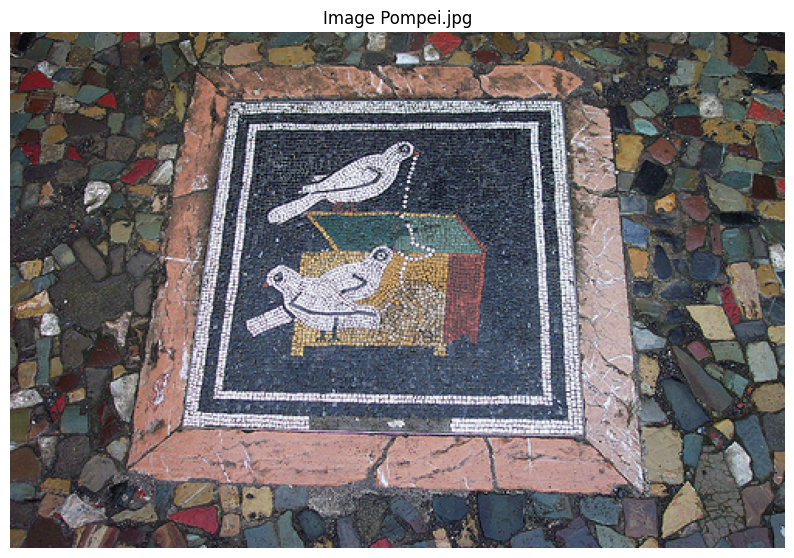

In [24]:
# Chargement de l'image Pompei
img = np.uint8(cv2.imread(PATH_IMG + "Pompei.jpg"))

(h, w, c) = img.shape
print("Dimension de l'image :", h, "lignes x", w, "colonnes x", c, "couleurs")

# Affichage de l'image pour référence
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Image Pompei.jpg")
plt.axis('off')
plt.show()

In [25]:
# Fonction de sélection de points avec la souris
def select_points(event, x, y, flags, param):
    global points_selected, X_init
    global img, clone
    if (event == cv2.EVENT_FLAG_LBUTTON):
        x_select, y_select = x, y
        points_selected += 1
        cv2.circle(img, (x_select, y_select), 8, (0, 255, 255), 1)
        cv2.line(img, (x_select-8, y_select), (x_select+8, y_select), (0, 255, 0), 1)
        cv2.line(img, (x_select, y_select-8), (x_select, y_select+8), (0, 255, 0), 1)
        X_init.append([x_select, y_select])
    elif event == cv2.EVENT_FLAG_RBUTTON:
        points_selected = 0
        X_init = []
        img = clone.copy()

# Initialisation
img = np.uint8(cv2.imread(PATH_IMG + "Pompei.jpg"))
clone = img.copy()
points_selected = 0
X_init = []

cv2.namedWindow("Image initiale")
cv2.setMouseCallback("Image initiale", select_points)

while True:
    cv2.imshow("Image initiale", img)
    key = cv2.waitKey(1) & 0xFF
    if (key == ord("q")) & (points_selected >= 4):
        break

cv2.destroyAllWindows()

# Conversion en array numpy
X_init = np.asarray(X_init, dtype=np.float32)
print("Points sélectionnés (X_init) =", X_init)
print("Nombre de points:", len(X_init))

Points sélectionnés (X_init) = [[140.  44.]
 [110. 255.]
 [370. 261.]
 [356.  44.]]
Nombre de points: 4


In [40]:
X_final = np.zeros((points_selected, 2), np.float32)
for i in range(points_selected):
    string_input = "Correspondant de {} ? ".format(X_init[i])
    X_final[i] = input(string_input).split(" ", 2)

print("Points de destination (X_final) =", X_final)

# This force the selections to be mapped into a square, which works very well to have a top-view

Points de destination (X_final) = [[140.  44.]
 [144. 294.]
 [394. 294.]
 [394.  44.]]


---
## Q3 : Estimation de l'homographie par SVD

**Question:** Pour estimer l'homographie, créez la matrice $2n \times 9$ $A$ comme indiqué en cours à partir de vos $n$ correspondances, puis résolvez le système $Ah = 0$ en utilisant la décomposition en valeurs singulières.

**Rappel de la méthode:**
1. Construire la matrice $A$ (dimension $2n \times 9$)
2. Résoudre $Ah = 0$ avec SVD
3. Normaliser les coordonnées avant, dé-normaliser après

### Questions à répondre:

**a) Quel est l'intérêt de normaliser les coordonnées ?**

The normalisation constrain is usefull because it help the numerical stability of the A martix before the SVD process.

**b) Quel indice de confiance pouvez-vous utiliser pour évaluer la fiabilité du résultat ?**

The best reliability it having the last 2 sigma ratio $\frac{\sigma_8}{\sigma_9}$ large.

### Implémentation de l'estimation d'homographie

In [27]:
def normalize_points(points):
    points = np.array(points, dtype=np.float64)
    
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    distances = np.sqrt(np.sum(centered**2, axis=1))
    mean_dist = np.mean(distances)
    scale = np.sqrt(2) / mean_dist if mean_dist > 0 else 1.0
    T = np.array([
        [scale, 0, -scale * centroid[0]],
        [0, scale, -scale * centroid[1]],
        [0, 0, 1]
    ], dtype=np.float64)
    normalized = centered * scale    
    return normalized, T

In [28]:
def build_matrix_A(X_src, X_dst):
    n = len(X_src)
    A = np.zeros((2 * n, 9), dtype=np.float64)
    
    for i in range(n):
        x, y = X_src[i, 0], X_src[i, 1]
        xp, yp = X_dst[i, 0], X_dst[i, 1]
        A[2 * i] = [-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * yp, y * yp, yp]
    
    return A

In [29]:
def estimate_homography(X_src, X_dst):
    X_src = np.array(X_src, dtype=np.float64)
    X_dst = np.array(X_dst, dtype=np.float64)
    
    X_src_norm, T_src = normalize_points(X_src)
    X_dst_norm, T_dst = normalize_points(X_dst)
    
    A = build_matrix_A(X_src_norm, X_dst_norm)
    
    U, S, Vt = np.linalg.svd(A)
    
    h = Vt[-1]
    H_norm = h.reshape(3, 3)
    
    # Step 6: Denormalize: H = T_dst^(-1) @ H_norm @ T_src
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    H = H / H[2, 2]
    
    print(f"{S}")
    
    return H

In [41]:
# Image worked well with this coordinates
# X_final = np.array([
#     [122, 25],   # Bottom-left  (corresponds to X_init[0])
#     [122, 300],   # Top-left     (corresponds to X_init[1])
#     [400, 300],   # Top-right    (corresponds to X_init[2])
#     [400, 25]    # Bottom-right (corresponds to X_init[3])
# ], dtype=np.float32)

H = estimate_homography(X_init, X_final)
print("Matrice d'homographie H:")
print(H)

[3.46797343 3.37707718 3.10678064 2.10847194 1.99639949 1.88825908
 1.22764095 1.21927188]
Matrice d'homographie H:
[[ 1.29952302e+00  3.65885309e-01 -4.87691284e+01]
 [ 5.11387106e-03  1.59247450e+00 -2.38735762e+01]
 [ 1.16224342e-04  1.13393695e-03  1.00000000e+00]]


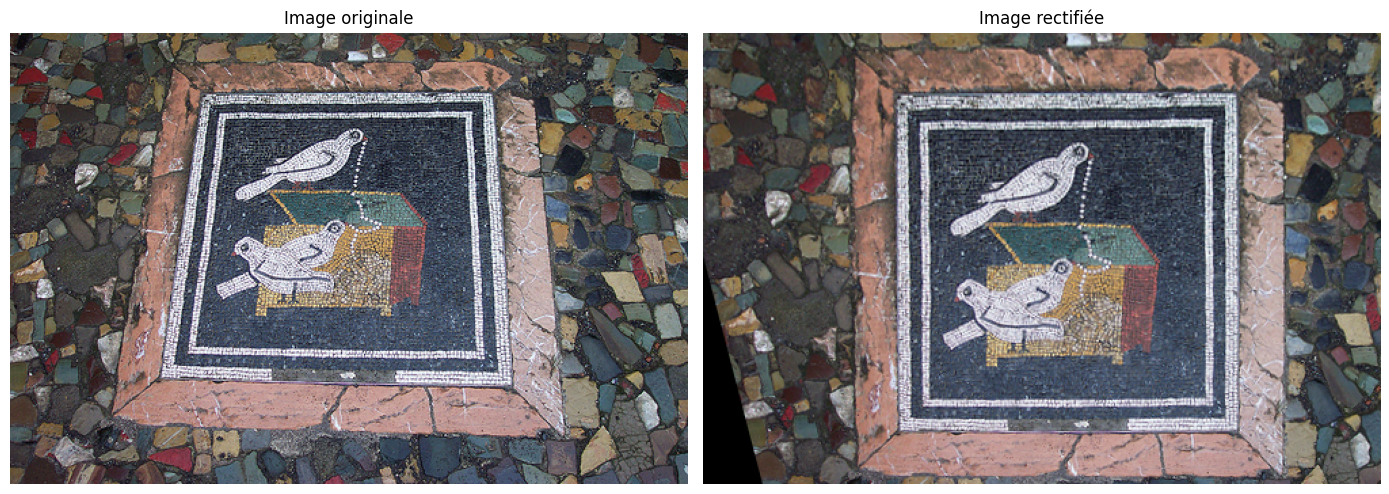

In [42]:
img_original = cv2.imread(PATH_IMG + "Pompei.jpg")
img_warp = cv2.warpPerspective(img_original, H, (w, h))

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image originale")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_warp, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image rectifiée")
axes[1].axis('off')

plt.tight_layout()
plt.show()

---
# Partie 3 : Création de panorama

## Q4 : Création de panorama par correspondances

**Question:** Modifier le script fourni afin de saisir les points par paires entre deux images, de façon à réaliser un panorama. Quelle condition doit respecter la prise de vue entre les deux images ?

### Votre réponse (condition de prise de vue):

*Écrivez votre réponse ici...*


In [33]:
# Chargement des deux images pour le panorama
# TODO: Adapter les noms de fichiers selon les images disponibles

# img1 = cv2.imread(PATH_IMG + "panorama1.jpg")
# img2 = cv2.imread(PATH_IMG + "panorama2.jpg")

# print("Image 1:", img1.shape)
# print("Image 2:", img2.shape)

In [34]:
def select_point_pairs(img1, img2):
    """
    Permet de sélectionner des paires de points correspondants entre deux images.
    
    TODO: Implémenter la sélection de points par paires
    - Afficher les deux images côte à côte ou alternativement
    - Permettre de cliquer sur un point dans img1 puis son correspondant dans img2
    - Retourner les deux listes de points
    """
    # TODO: Votre code ici
    pass

In [35]:
def create_panorama(img1, img2, H):
    """
    Crée un panorama en combinant img1 et img2 avec l'homographie H.
    
    TODO: Implémenter la création du panorama
    - Calculer la taille du canvas de sortie
    - Warper img2 vers le repère de img1
    - Combiner les deux images
    """
    # TODO: Votre code ici
    pass

In [36]:
# TODO: Code pour créer le panorama
# 1. Sélectionner les paires de points
# 2. Estimer l'homographie
# 3. Créer le panorama

---
## Q5 : Paramètres de la transformation

**Question:** Comment retrouver les paramètres de cette transformation à partir de ceux de l'homographie ?

### Votre réponse:

*Écrivez votre réponse ici...*

**Indice:** Pensez à la décomposition de l'homographie en rotation, translation, et paramètres intrinsèques.


In [37]:
def decompose_homography(H, K=None):
    """
    Décompose l'homographie pour extraire les paramètres de transformation.
    
    TODO: Implémenter la décomposition de H
    """
    # TODO: Votre code ici
    pass

---
## Q6 : Uniformisation des couleurs

**Question:** Proposer une stratégie d'uniformisation des couleurs entre les deux images visant à éviter les défauts photométriques à la jonction entre les deux images.

### Votre réponse:

*Décrivez votre stratégie ici...*

**Pistes possibles:**
- 
- 
- 

In [38]:
def blend_images(img1, img2_warped, overlap_region):
    """
    Fusionne deux images avec uniformisation des couleurs.
    
    TODO: Implémenter votre stratégie d'uniformisation
    - Égalisation d'histogramme?
    - Blending linéaire dans la zone de chevauchement?
    - Multi-band blending?
    - Correction de gain/offset?
    """
    # TODO: Votre code ici
    pass

In [39]:
# TODO: Tester votre stratégie d'uniformisation sur le panorama

---
# Résumé et Conclusions

### Ce que j'ai appris:

1. 
2. 
3. 

### Difficultés rencontrées:

- 
- 

### Améliorations possibles:

- 
- 